## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from scipy.optimize import fsolve
from variaIa.variaIa import baserate
from scipy.interpolate import interp1d
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt
import random

## Définitions et sélection de l'échantillon à utiliser

In [2]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'PS1')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

def set_data(su):
    global ns_dataz, dataz, ns_datax, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
    if su == 'SNLS':
        dataz = np.sort(surv[su].zCMB.values)
        # [np.where(surv[su].zCMB.values > .4)]
    else:
        dataz = np.sort(surv[su].zCMB.values)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

# Détermination des $z_{\text{max}}$ _via_ baserate

## Calcul pour l'échantillon choisi

In [50]:
reload(baserate)

itsc = {'SDSS': [.9, .5, .05],
        'PS1': [.9, .5, .05],
        'SNLS': [.65, .5, .22]}
guess = .2
loops = 100

res_one = {su.value: baserate.zmax_poisson(su.value, dataz, guess, loops, itsc[su.value])}

## Tracé pour l'échantillon choisi

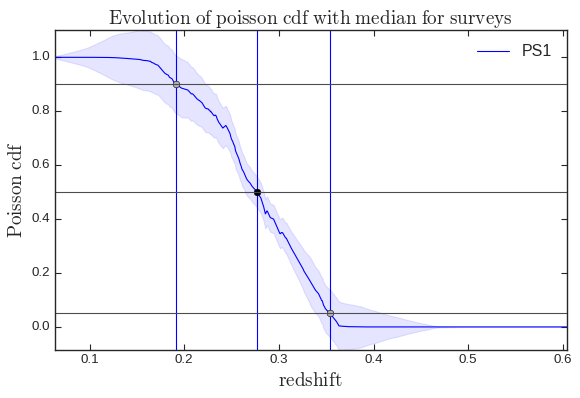

In [51]:
reload(baserate)

z_lin = {su.value: res_one[su.value][0]}
med = {su.value: res_one[su.value][1]}
std = {su.value: res_one[su.value][2]}
maxx = {su.value: res_one[su.value][3]}

baserate.zmax_pshow(z_lin, med, std, maxx, itsc[su.value], True, True)

## Tracé pour l'échantillon choisi depuis données sauvegardées

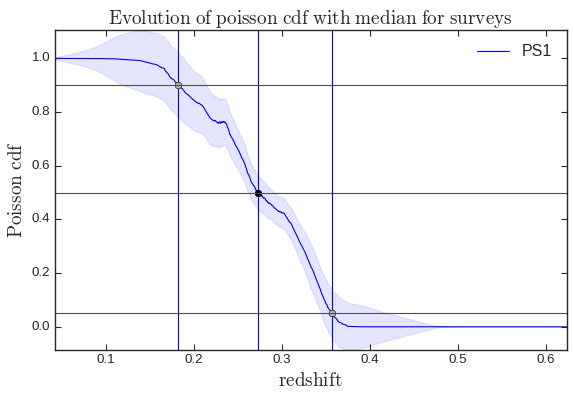

In [4]:
reload(baserate)

with open('../Data/zmax_spec_result', 'rb') as f:
    z_lins, meds, stds, z_max, itsc = pickle.load(f)

z_lins_one = {su.value: z_lins[su.value]}
meds_one = {su.value: meds[su.value]}
stds_one = {su.value: stds[su.value]}
z_max_one = {su.value: z_max[su.value]}

baserate.zmax_pshow(z_lins_one, meds_one, stds_one, z_max_one,
                    itsc, True, True)

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/zmax_' + str(su.value) +
#'_095_stds_point.pdf', bbox_inches='tight')

## Tracé des trois échantillons

### Dictionnaires des z_intp, meds, stds et z_max ± inf/sup

In [78]:
reload(baserate)

res = dict()
meds = dict()
stds = dict()
z_lins = dict()
z_max = dict()

itsc = {'SDSS': [.85, .5, .05],
        'PS1': [.9, .5, .05],
        'SNLS': [.65, .5, .25]}
guess = .2
loops = 1000

for survey in surveys[1:-1]:
    res[survey] = baserate.zmax_poisson(survey,
                                        np.sort(surv[survey].zCMB.values),
                                        guess, loops, itsc)
    z_lins[survey] = res[survey][0]
    meds[survey] = res[survey][1]
    stds[survey] = res[survey][2]
    z_max[survey] = res[survey][3]

### Résultats et sauvegarde

In [7]:
z_max

{'SDSS': [0.1728, 0.2039, 0.2301],
 'PS1': [0.1821, 0.2732, 0.3568],
 'SNLS': [0.5937, 0.6162, 0.6565]}

#### Attention en m'écrasant !

In [73]:
with open('../Data/zmax_null_result', 'wb') as f:
    pickle.dump([z_lins, meds, stds, z_max, itsc], f)

### Tracé effectif

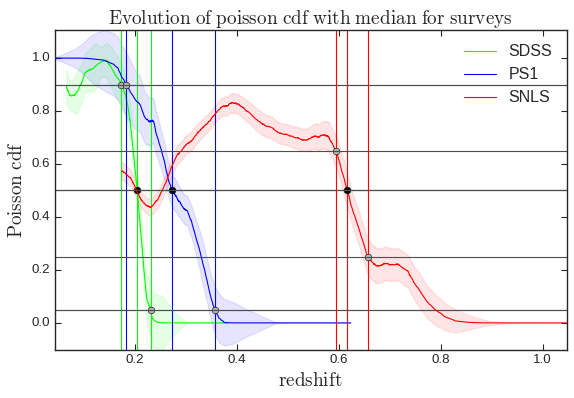

In [6]:
reload(baserate)

with open('../Data/zmax_spec_result', 'rb') as f:
    z_lins, meds, stds, z_max, itsc = pickle.load(f)

baserate.zmax_pshow(z_lins, meds, stds, z_max, itsc, True, True)

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/zmax_all_0802_stds_point.pdf')